In [1]:
# 6章：GoogleColaboratory上で実行
# chapter06.ipynb's directory: /content/drive/My Drive/Colab Notebooks/nlp100knock/
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/nlp100knock/"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/nlp100knock


In [2]:
# 50. データの入手・整形
# データセットは事前にダウンロード、解凍して data/ch06/ にアップロード
import re
from sklearn.model_selection import train_test_split

with open('data/ch06/newsCorpora.csv') as f:
    lines = f.readlines()

publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
extract_data = []

for num, line in enumerate(lines):
    # 指定情報源の記事のみを抽出
    line_splited = re.findall('(?:\d+)\t(?P<title>.*?)\t(?:.*?)\t(?P<publisher>.*?)\t(?P<category>[betm])', line)
    if line_splited[0][1] in publishers:
        extract_data.append(f'{line_splited[0][2]}\t{line_splited[0][0]}')

# データの分割
train_data, other_data = train_test_split(extract_data, test_size=0.2, random_state=0)
valid_data, test_data = train_test_split(other_data, test_size=0.5, random_state=0)

# データの保存
with open('data/ch06/train.txt', 'w') as f:
    f.write('\n'.join(train_data))
with open('data/ch06/valid.txt', 'w') as f:
    f.write('\n'.join(valid_data))
with open('data/ch06/test.txt', 'w') as f:
    f.write('\n'.join(test_data))

**各カテゴリの事例数**

cmd: cut -f 1 train.txt | sort | uniq -c | sort -nr
- train.txt -> b:4537, e:4200, t:1220, m:727
- valid.txt -> b:556, e:539, t:152, m:89
- test.txt  -> b:551, e:538, t:153, m:94

In [ ]:
# 51. 特徴量抽出
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

train_df = pd.read_table('data/ch06/train.txt', names=('category', 'title'))
valid_df = pd.read_table('data/ch06/valid.txt', names=('category', 'title'))
test_df = pd.read_table('data/ch06/test.txt', names=('category', 'title'))

vectorizer = CountVectorizer()      # 単語カウントを特徴量として抽出
vectorizer.fit(train_df['title'])   # 単語辞書の学習

train_X = vectorizer.transform(train_df['title'])
valid_X = vectorizer.transform(valid_df['title'])
test_X = vectorizer.transform(test_df['title'])

np.savetxt('data/ch06/train.feature.txt', train_X.toarray(), fmt='%d')
np.savetxt('data/ch06/valid.feature.txt', valid_X.toarray(), fmt='%d')
np.savetxt('data/ch06/test.feature.txt', test_X.toarray(), fmt='%d')

np.savetxt('data/ch06/feature_names_out.txt', vectorizer.get_feature_names_out(), fmt='%s') # 単語辞書を保存

In [ ]:
# 52. 学習
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

X_train = np.loadtxt('data/ch06/train.feature.txt') # 10684, 12802
train_df = pd.read_table('data/ch06/train.txt', names=('category', 'title'))
Y_train = train_df['category']  # 10684,

lr = LogisticRegression(max_iter=200) # ロジスティック回帰モデルの作成
lr.fit(X_train, Y_train)  # ロジスティック回帰モデルの学習

# Warning: 最大反復回数(default: 100iter)までに収束していない

LogisticRegression(max_iter=200)

In [ ]:
# 53. 予測
# lr: 52で学習したロジスティック回帰モデル
def predict_categorys(title):
    '''
    input:  記事見出しの特徴量(n_samples, n_features)
    output: カテゴリ, 予測確率(n_samples, 2)
    '''
    category_dict = {'b':0, 'e':1, 'm':2, 't':3}
    results = []

    result_categorys = lr.predict(title)      # (n_samples,)
    result_probas = lr.predict_proba(title)   # (n_samples, n_classes)

    for num, result_category in enumerate(result_categorys):
        # 各sampleのカテゴリと予測確率をappend
        category_num = category_dict[result_category]
        results.append([result_category, result_probas[num][category_num]])

    return results

test_features = np.loadtxt('data/ch06/test.feature.txt')

# 評価データのカテゴリとその予測確率を計算(ここでは最初の3つのみ計算)
sample_results = predict_categorys(test_features[:3].reshape(3,-1))

print(f'[\'category\', proba]:{sample_results}')

['category', proba]:[['b', 0.993452350314459], ['b', 0.9995044443467324], ['b', 0.9782338258176773]]


In [ ]:
# 54. 正解率の計測
from sklearn.metrics import accuracy_score

# lr: 52で学習したロジスティック回帰モデル
# X/Y_train: 52参照
train_true = Y_train
train_pred = lr.predict(X_train)

print(f'train accuracy: {accuracy_score(train_true, train_pred)}')


X_test = np.loadtxt('data/ch06/test.feature.txt')
test_df = pd.read_table('data/ch06/test.txt', names=('category', 'title'))
Y_test = test_df['category']

test_true = Y_test
test_pred = lr.predict(X_test)

print(f'test accuracy : {accuracy_score(test_true, test_pred)}')

train accuracy: 0.9959752901535006
test accuracy : 0.905688622754491


In [ ]:
# 55. 混同行列の作成
from sklearn.metrics import confusion_matrix

# train/test_true/pred: 54参照
print(f'train confusion matrix (b, e, m, t):\n{confusion_matrix(train_true, train_pred)}')

print(f'\ntest confusion matrix (b, e, m, t):\n{confusion_matrix(test_true, test_pred)}')

train confusion matrix (b, e, m, t):
[[4481    3    1    8]
 [   7 4234    0    2]
 [   0    2  717    0]
 [  16    4    0 1209]]

test confusion matrix (b, e, m, t):
[[551  10   3  15]
 [ 11 501   0   4]
 [ 17  16  68   3]
 [ 30  16   1  90]]


In [ ]:
# 56. 適合率，再現率，F1スコアの計測
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import precision_recall_fscore_support

# カテゴリごとに適合率、再現率、F1スコアを求める
print(f'precision score\t(b, e, m, t): {precision_score(test_true, test_pred, average=None)}')
print(f'recall score\t(b, e, m, t): {recall_score(test_true, test_pred, average=None)}')
print(f'f1 score\t(b, e, m, t): {f1_score(test_true, test_pred, average=None)}')
# print(precision_recall_fscore_support(test_true, test_pred))

# マイクロ平均、マクロ平均で統合
print(f'\nprecision score\t(micro average): {precision_score(test_true, test_pred, average="micro")}')
print(f'recall score\t(micro average): {recall_score(test_true, test_pred, average="micro")}')
print(f'f1 score\t(micro average): {f1_score(test_true, test_pred, average="micro")}')
# print(f'micro averages: {precision_recall_fscore_support(test_true, test_pred, average="micro")}')

print(f'\nprecision score\t(macro average): {precision_score(test_true, test_pred, average="macro")}')
print(f'recall score\t(macro average): {recall_score(test_true, test_pred, average="macro")}')
print(f'f1 score\t(macro average): {f1_score(test_true, test_pred, average="macro")}')
# print(f'macro averages: {precision_recall_fscore_support(test_true, test_pred, average="macro")}')

precision score	(b, e, m, t): [0.9047619  0.92265193 0.94444444 0.80357143]
recall score	(b, e, m, t): [0.95164076 0.97093023 0.65384615 0.65693431]
f1 score	(b, e, m, t): [0.92760943 0.94617564 0.77272727 0.72289157]

precision score	(micro average): 0.905688622754491
recall score	(micro average): 0.905688622754491
f1 score	(micro average): 0.905688622754491

precision score	(macro average): 0.8938574278698588
recall score	(macro average): 0.8083378632261379
f1 score	(macro average): 0.8423509759988821


In [ ]:
# 57. 特徴量の重みの確認
# lr.coef_: ロジスティック回帰モデルの回帰係数行列 (4, 12802)
# 回帰係数の分散が大きいものほど重要として計算
coef_var = np.var(lr.coef_, axis=0)  # 行ごとの分散を求める
most_important_features = np.argsort(coef_var)[-10:]
least_important_features = np.argsort(coef_var)[:10]

print(f'most important words : {list(vectorizer.get_feature_names_out()[most_important_features])}')
print(f'least important words: {list(vectorizer.get_feature_names_out()[least_important_features])}')

most important words : ['bank', 'gm', 'cancer', 'fda', 'climate', 'microsoft', 'apple', 'facebook', 'ebola', 'google']
least important words: ['upstage', 'narrowed', 'sneaking', 'active', 'christmas', 'outsell', 'tone', 'disses', 'reminds', 'brushed']


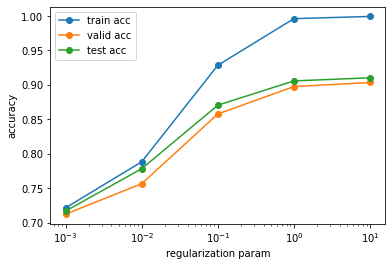

In [ ]:
# 58. 正則化パラメータの変更
# 正則化パラメータを調整し、学習/検証/評価データ上の正解率を求める
# グラフ  横軸：正則化パラメータ, 縦軸：正解率
import matplotlib.pyplot as plt

# 正則化パラメータ
c_array = [0.001, 0.01, 0.1, 1, 10]

# 各パラメータにおける正解率を記録
train_accs = []
valid_accs = []
test_accs  = []

# 検証データの準備
X_valid = np.loadtxt('data/ch06/valid.feature.txt')
valid_df = pd.read_table('data/ch06/valid.txt', names=('category', 'title'))
Y_valid = valid_df['category']

valid_true = Y_valid

for c in c_array:
    # モデルの構築・学習 (X/Y_train: 52参照)
    lr_model = LogisticRegression(C=c, max_iter=200)
    lr_model.fit(X_train, Y_train)

    # 予測
    train_pred = lr_model.predict(X_train)
    valid_pred = lr_model.predict(X_valid)
    test_pred  = lr_model.predict(X_test)

    # 正解率の計算
    train_accs.append(accuracy_score(train_true, train_pred))
    valid_accs.append(accuracy_score(valid_true, valid_pred))
    test_accs.append(accuracy_score(test_true, test_pred))

# グラフの描写
p1 = plt.plot(c_array, train_accs, marker='o')
p2 = plt.plot(c_array, valid_accs, marker='o')
p3 = plt.plot(c_array, test_accs, marker='o')
plt.xscale('log')
plt.xlabel('regularization param')
plt.ylabel('accuracy')
plt.legend((p1[0], p2[0], p3[0]), ('train acc', 'valid acc', 'test acc'))
plt.show()

In [ ]:
# 59. ハイパーパラメータの探索
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# 学習データと検証データを統合
X_train_valid = np.concatenate([X_train, X_valid]) 
Y_train_valid = pd.concat([Y_train, Y_valid])

# ランダムサーチを用いた探索
logistic = LogisticRegression(max_iter=200)
distributions = dict(C=uniform(loc=0, scale=10), solver=['newton-cg', 'lbfgs', 'sag'])

clf = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=2)
search = clf.fit(X_train_valid, Y_train_valid)

# 最適化された学習アルゴリズム・パラメータ
print(f'best param & solver: {search.best_params_}')

# 評価データでの正解率
test_pred = clf.predict(X_test)
print(f'test accuracy: {accuracy_score(test_true, test_pred)}')

best param & solver: {'C': 5.4881350392732475, 'solver': 'lbfgs'}
test accuracy: 0.9139221556886228
